#IEOR 4500 HW 1 due September 18

Use the data in "russell_prices.txt" available on Courseworks, for 947 assets
over 504 days

1. Compute sample mean returns and sample covariance matrix.
2. Implement coordinate descent algorithm for mean-variance portfolio optimization problem.  Here each asset can have weight between 0 and 1.  You can use Python, Java, C or C++.
3. For lambda = 0, how many assets do you have in your optimal basket, and what risk (total variance) do you have?
4. Plot an approximate risk (variance) v. return curve by running the optimization over different choices of lambda.  What is the smallest variance you see
in any of these optimizations?
5. Let s2_0 be the variance you reported in #3, and let s2_min be the variance
you reported in #4.  Define s2_mid = 0.5(s2_0 + s2_min).  Estimate the value of
lambda needed so that your optimal portfolio has variance s2_mid.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Part 1
df = pd.read_csv('russell_prices.txt', sep=' ', header=None, skiprows=2)  # Dropping first two rows
df = df.drop(504, 1)
data = df.to_numpy()

# Calculating returns #df.apply(lambda x: (x[j]-x[j-1]) / x[j-1], axis=1)
sample_returns=(data[:,1:504]-data[:,0:503])/data[:,0:503]

# Calculating Means of returns
sample_mean_returns = np.mean(sample_returns, axis=1)#mu's computed

# Calculating Covariance Matrix of returns
sample_cov_matrix = np.cov(sample_returns)

# Part 2

def get_feasible_x(l, u):
    # step 1: get feasible solution
    # Assigning lower limit to all values of x
    x = np.array(l)
    
    # Checking if summation of x is exceeding 1, problem would be infeasible (no solution exist)
    if x.sum() > 1:
        raise Exception('The problem is infeasible! Sum of all lower bounds larger than 1')
    # Checking if summation of x is close to 1
    elif abs(x.sum() - 1) < 0.01:
        return x
    else:
        i = 0
        while x.sum() <= 1 and i <= 946:
            if 1 - x.sum() <= (u[i] - l[i]):
                x[i] = x[i] + 1 - x.sum()
                return x
            else:
                x[i] = u[i]
                i += 1
                    # If all of the above conditions does not staisfy, 
                    #it means summation of smaller than 1 and x = u(upper limit), feasible solution does not exist
    raise Exception('The problem is infeasible! Sum of all upper bounds smaller than 1')

def get_a_b(h, k, cov_matrix, lamda, x, returns):

    a = lamda*(cov_matrix[h, h]+cov_matrix[k, k]+2 * cov_matrix[h, k])
    
    sums=sum((cov_matrix[:,k]-cov_matrix[:,h])*x[:]+  x[h]*(cov_matrix[h, k] - cov_matrix[h, h])
             + x[k]*(cov_matrix[k,k]-cov_matrix[h,k]))
    
    b = 2 * lamda*(sums-(cov_matrix[h,k]-cov_matrix[h,h])*x[h]-(cov_matrix[k,k]-cov_matrix[k,h])*x[k])+(returns[h] - returns[k])
    return a,b

def find_shift(l, u, h, k, cov_matrix, lamda, x, returns):
    a, b = get_a_b(h, k, cov_matrix, lamda, x, returns)
    max_shift = min(x[h] - l[h], u[k] - x[k])
    min_shift = min(u[h] - x[h], x[k] - l[k])
    if a != 0:
        # have first derivative = zero
        shift = -b / (2 * a)
        if -min_shift <= shift and shift <= max_shift:
            return shift
        elif shift < -min_shift:
            return -min_shift
        else:
            return max_shift
    else:
        # when a==0, to minimize the expression b*shift
        if b >= 0:
            return -min_shift
        else:
            return max_shift
def mean_variance_opt(l, u, lamda, sample_cov_matrix, sample_mean_returns, max_count=10000):
    # first step get x.sum to 1
    x = get_feasible_x(l, u)
    count = 0
    while(count<=max_count):
        for h in range(946):
            for k in range(h + 1, 947):
                if x[h] == l[h] and x[k] == l[k]:
                    continue
                count += 1
                if count >= max_count:
                    return x
                shift = find_shift(l, u, h, k, sample_cov_matrix, lamda, x, sample_mean_returns)
                x[k] += shift
                x[h] -= shift
    return x
    

when lambda=0, total risk of my optimal basket is: 0.0186367839338458
Total number of asset in my basket is: 1


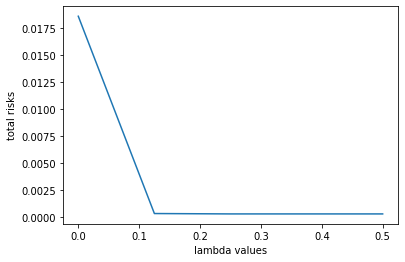

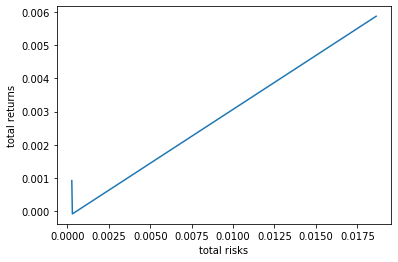

min variance I have is: 0.0002638014749830368
medium risk is: 0.009450292704414418
The lambda estimate for s2_mid is: 0.06261985676109463


In [88]:
# Set lower & upper bounds bound of x
l = np.full(947, 0, dtype=float)
u = np.full(947, 1, dtype=float)
x = mean_variance_opt(l, u, 0, sample_cov_matrix, sample_mean_returns)
# Finding total risks
def total_risk(x, cov_matrix):
    return np.dot(np.dot(x, cov_matrix), x.T)
def total_return(x, sample_mean_returns):
    return np.dot(x, sample_mean_returns)

# Question 3
s2_0 = total_risk(x, sample_cov_matrix)
print('when lambda=0, total risk of my optimal basket is:', s2_0)
print('Total number of asset in my basket is:', np.count_nonzero(x))

# Question 4

# Creating list of lamba ranging from 0 to 0.5 with an increment step of 0.125
lam = [i for i in np.linspace(0, 0.5, 5)]
risks = []
returns=[]
for lamda in lam:
    risks.append(total_risk(mean_variance_opt(l, u, lamda, sample_cov_matrix, sample_mean_returns), sample_cov_matrix))
    returns.append(total_return(mean_variance_opt(l, u, lamda, sample_cov_matrix, sample_mean_returns),sample_mean_returns))

# Plotting the graph of risk vs lambda
plt.plot(lam, risks)
plt.ylabel('total risks')
plt.xlabel('lambda values')
plt.savefig('HW1 Q4 Plot of variance.png')
plt.show() 

#plot risk vs return 
plt.plot(risks, returns)
plt.ylabel('total returns')
plt.xlabel('total risks')
plt.show() 


# Calculating minimum risk amongst all values of given risks
min_risk = min(risks)
print('min variance I have is:', min_risk)

#question5
# Calculating mid risk
s2_mid = (s2_0 + min_risk) / 2
print('medium risk is:', s2_mid)

# Interpolating the value of lambda at mid risk by calculating function f
f = interp1d(risks, lam)
print('The lambda estimate for s2_mid is:', f(s2_mid))
